# 1 - Logistic Regression for Musical Tags
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/annabavaresco/ancm2025/blob/main/docs/week_1/1_Logistic_regression_for_musical_tags.ipynb)
[![View filled in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annabavaresco/ancm2025/blob/main/docs/week_1/1_Logistic_regression_for_musical_tags.ipynb)

*Adapted form materials created by Marianne de Heer Kloots & Ashley Burgoyne, September 2022*

---

Welcome to your first ANCM lab! This session focuses on how logistic models can be useful not just as discrete classifiers but also as a means to develop an interpretable continuous measurement. In other words, your goal is not to develop the best classifier *per se*, but rather a continuous measure that you can *explain*. Your deliverable for the submission will be a short description of your model, your measurement, and a qualitative description (based on your own listening) of how well your measurement seems to capture a musical concept (250–500 words).

What kind of musical concept? The lab works with a widely-used dataset in music information retrieval (MIR) known as the [MagnaTagATune dataset](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset). This dataset is normally used for its clean and consensus-based collection of _tags_ that participants in an online experiment chose to associate with 31&nbsp;000 clips of open-source music from the [Magnatune](http://magnatune.com) collection.

You may be familiar with the concept of a music tag from the [last.fm](https://www.last.fm) service. In brief, a tag it is any user-defined label that a listener chooses associate with a track they are hearing. Tags can be highly personal and specific (e.g., *dark rainy city*), but as researchers, we are most interested in tags that many different listeners independently chose to associate with a track. The key advantage of tags over marketing-driven categories like genre, which are ultimately oriented more toward predicting sales or streams than the audio content itself, is that tags can be a better representation of listeners’ conceptualisation of the music that they hear.

## Loading the data

We will work with a set of features computed by a convolutional neural network model (specifically the TUNe+ architecture, which expand the widely used [U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)), trained to learn a self-supervised music representation from audio. You will learn more about these architectures next week, but if you would like to read more about the specifics of the model already, read [this paper](https://ismir2022program.ismir.net/poster_109.html) by Vélez Vázquez and Burgoyne.

For this lab, however, all you need to know about the TUNe+ representation is that it consists of a 512-dimensional extracted feature vector for each of the 25.000+ audio clips in MagnaTagATune. Self-supervised networks learn *without* reference to any specific task or ground truth, and so in principle, it is an open question whether the TUNe+ representation has learned anything useful for music tagging. Your job is to find a feature (or set of features) in this representation that seem to generate a good prediction of one or more of the MagnaTagATune tags.

To load the features into your colab environment, go here and click add shortcut to drive (plus symbol in the top right): [tune_plus.zip](https://drive.google.com/file/d/1Oi3JKQQQGuU2wg6Xru4WP3Z0eRTpiYtq/view?usp=sharing)

Then link your google drive to colab (run the code cell below):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the files into a folder (you will be able to find this folder if you click the folder icon in your left sidebar). Make sure you update the path below with the correct location in your GG Drive file system.

In [ ]:
!unzip -qq '/content/drive/MyDrive/tune_plus.zip'

Now we download the tag annotations from the [MagnaTagATune dataset](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset).

In [ ]:
!wget -q 'https://mirg.city.ac.uk/datasets/magnatagatune/annotations_final.csv'

Great! Now we have all the data we need. Let's import some useful libraries and load both the features and annotations into separate [pandas DataFrames](https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe). Have a look at the content of the dataframes below.

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from IPython.display import Audio
from IPython.display import display

In [ ]:
features_dir = 'tune_plus/'
annotations_df = pd.read_csv('annotations_final.csv', sep='\t')

# remove three missing clips from the annotations dataframe
missing_clips = [clip_id for clip_id in annotations_df['clip_id'] if not os.path.exists(features_dir + str(clip_id).zfill(5) + '.npy')]
annotations_df = annotations_df.drop(annotations_df[annotations_df['clip_id'].isin(missing_clips)].index)

# standardise the features and use the clip_ids as row names
annotations_df = annotations_df.set_index('clip_id')
raw_features_df = pd.DataFrame.from_dict({clip_id: np.load(features_dir + str(clip_id).zfill(5) + '.npy')
                                         for clip_id in annotations_df.index}, orient='index')
features_df = pd.DataFrame(StandardScaler().fit_transform(raw_features_df))
features_df.index = raw_features_df.index
features_df.index.name = 'clip_id'

In [ ]:
# row names are clip_id, last column is the mp3 file location, all other columns are binary 1/0 annotations for each tag

annotations_df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


In [ ]:
# all_tags contains all tags present in the MagnaTagATune annotations (all columns except for mp3_path)
all_tags = [col for col in annotations_df.columns if col != 'mp3_path']
pprint(all_tags)

['no voice',
 'singer',
 'duet',
 'plucking',
 'hard rock',
 'world',
 'bongos',
 'harpsichord',
 'female singing',
 'clasical',
 'sitar',
 'chorus',
 'female opera',
 'male vocal',
 'vocals',
 'clarinet',
 'heavy',
 'silence',
 'beats',
 'men',
 'woodwind',
 'funky',
 'no strings',
 'chimes',
 'foreign',
 'no piano',
 'horns',
 'classical',
 'female',
 'no voices',
 'soft rock',
 'eerie',
 'spacey',
 'jazz',
 'guitar',
 'quiet',
 'no beat',
 'banjo',
 'electric',
 'solo',
 'violins',
 'folk',
 'female voice',
 'wind',
 'happy',
 'ambient',
 'new age',
 'synth',
 'funk',
 'no singing',
 'middle eastern',
 'trumpet',
 'percussion',
 'drum',
 'airy',
 'voice',
 'repetitive',
 'birds',
 'space',
 'strings',
 'bass',
 'harpsicord',
 'medieval',
 'male voice',
 'girl',
 'keyboard',
 'acoustic',
 'loud',
 'classic',
 'string',
 'drums',
 'electronic',
 'not classical',
 'chanting',
 'no violin',
 'not rock',
 'no guitar',
 'organ',
 'no vocal',
 'talking',
 'choral',
 'weird',
 'opera',
 'so

In [ ]:
# row names are clip_id, column names are feature index
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
clip_id,,,,,,,,,,,,,,,,,,,,,
2,-0.378277,-0.062457,-0.510482,-0.480929,-0.480325,-0.454518,-0.443122,-0.493741,-0.213347,2.126731,...,-0.291182,-0.466146,0.551430,1.003683,-0.113972,-0.421089,-0.255160,-0.354635,-0.050093,-0.389713
6,-0.376851,0.296082,-0.484719,-0.480929,-0.433477,-0.352741,-0.486704,-0.493741,0.150385,2.665289,...,-0.291182,-0.466146,0.307409,1.013029,-0.070639,-0.421089,0.257779,-0.327240,-0.386583,-0.388235
10,-0.461711,-0.052404,-0.461220,-0.480929,-0.561454,-0.300693,-0.524904,-0.435769,-0.172081,2.452786,...,-0.291182,-0.466146,0.527835,1.004471,0.130523,-0.421089,-0.177004,-0.354635,-0.345239,-0.056744
11,-0.448789,-0.379482,-0.510482,-0.470660,-0.453445,-0.536019,-0.524904,-0.277493,-0.388461,1.073273,...,-0.291182,-0.466146,0.566224,0.950023,-0.205476,-0.406373,0.466494,-0.352163,-0.084332,-0.320166
12,-0.440095,-0.405996,-0.504078,-0.480929,-0.441189,-0.436168,-0.524904,-0.299977,-0.217573,1.405112,...,-0.291182,-0.466146,0.451640,0.815182,0.495791,-0.421089,0.842923,-0.332279,-0.349359,-0.360313


Each clip has a unique `clip_id`, used as the row names in both dataframes. This is how we know which features, tag annotations and mp3 files belong to eachother. In `annotations_df`, you can get the 0/1 values of a particular tag like 'harpsichord' for all clips using the column names: `annotations_df['harpsichord']`. In `features_df`, you can similarly use the columns to get the values of a single feature (like the 204th one out of 512) using `features_df[203]` (remember Python is zero-indexed).

Note that even though we standardised the feature values, they are not at all bell shaped! All of the features have a mode just below 0 with a long right tail. Here is histogram of feature 0, for example.

array([[<Axes: title={'center': '0'}>]], dtype=object)

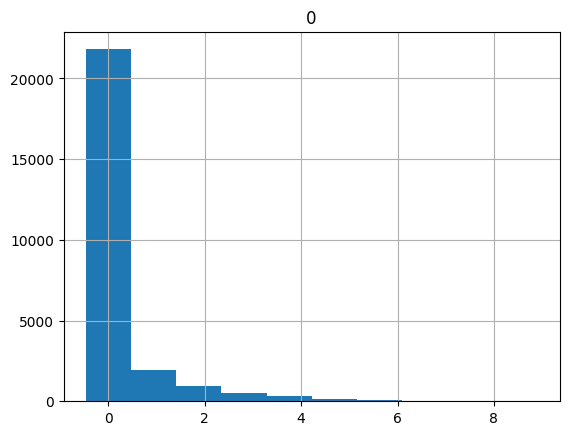

In [ ]:
features_df.hist(0)

Let's also load the actual mp3 files so we can listen to some clips. We need to add a shortcut to your Google drive again, but now for the following zip file: [mp3.zip](https://drive.google.com/file/d/18rAysjGrlJvAKaRJIj47jHObUoEfnE6G/view?usp=sharing). Then also unzip this one into a folder:

In [ ]:
!unzip -qq '/content/drive/MyDrive/PhD/ANCM/Lab Materials 2024/mp3.zip'
# !unzip -qq '/content/drive/MyDrive/mp3.zip'

Now you can listen to the audio for any `clip_id` you'd like (enjoy!):

In [ ]:
my_clip = 58907
sound_file = annotations_df.loc[my_clip, 'mp3_path']
sound_audio = Audio(sound_file)
display(sound_audio)

Here's a quick function to find the positive tag annotations (all columns that have a 1) for any `clip_id`.

In [ ]:
def get_tags(clip_id):
  return [col for col in annotations_df.columns if annotations_df.loc[clip_id, col] == 1]

tags_for_my_clip = get_tags(my_clip)
print(tags_for_my_clip)

['classical', 'guitar', 'strings', 'slow']


Do you agree?

(Below are all tags *not* chosen – or at least not chosen by many people – for this particular clip.)

In [ ]:
print([tag for tag in all_tags if not tag in tags_for_my_clip])

['no voice', 'singer', 'duet', 'plucking', 'hard rock', 'world', 'bongos', 'harpsichord', 'female singing', 'clasical', 'sitar', 'chorus', 'female opera', 'male vocal', 'vocals', 'clarinet', 'heavy', 'silence', 'beats', 'men', 'woodwind', 'funky', 'no strings', 'chimes', 'foreign', 'no piano', 'horns', 'female', 'no voices', 'soft rock', 'eerie', 'spacey', 'jazz', 'quiet', 'no beat', 'banjo', 'electric', 'solo', 'violins', 'folk', 'female voice', 'wind', 'happy', 'ambient', 'new age', 'synth', 'funk', 'no singing', 'middle eastern', 'trumpet', 'percussion', 'drum', 'airy', 'voice', 'repetitive', 'birds', 'space', 'bass', 'harpsicord', 'medieval', 'male voice', 'girl', 'keyboard', 'acoustic', 'loud', 'classic', 'string', 'drums', 'electronic', 'not classical', 'chanting', 'no violin', 'not rock', 'no guitar', 'organ', 'no vocal', 'talking', 'choral', 'weird', 'opera', 'soprano', 'fast', 'acoustic guitar', 'electric guitar', 'male singer', 'man singing', 'classical guitar', 'country', 'v

## Logistic regression

Using the popular `sklearn` library, we will start by building some very simple logistic regression models, with an aim at understanding the output, and build up to more complex models.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### First for 1 feature and 1 tag

For starters, let's begin with the simplest possible question: do any of the TUNe+ features correspond directly to human tagging preferences for one of the MagnaTagATune tags? We set this up as a logistic regression with a single feature predicting a single tag. Try different features and tags until you find one with decent performance.

In [ ]:
# choose the tag you would like to model (see annotations_df.columns for all tags)
my_favourite_tag = annotations_df['lol']

# choose the feature to predict your tag (change 0 to any other number in feature_df.columns)
my_favourite_feature = features_df[203]

In [ ]:
# create train and test split
x_train_single, x_test_single, y_train_single, y_test_single = train_test_split(my_favourite_feature, my_favourite_tag, test_size=0.25, random_state=0)

# the clip_ids in the train and test splits
clips_train_single, clips_test_single = y_train_single.index.values, y_test_single.index.values

# when only using a single feature, we need to reshape the input arrays
x_train_single = x_train_single.values.reshape(-1, 1)
x_test_single = x_test_single.values.reshape(-1, 1)

In [ ]:
single_feature_model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=0
    )
single_feature_model.fit(x_train_single, y_train_single)

LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')

We can look at the coefficients of our model to see how strong the relationship between our feature and our tag would be. Remember Gelman's rule of thumb for interpreting logistic regression coefficients: if you divide them by 4, they give you an upper bound on how much the predicted probability of a clip being tagged a particular tag changes for every standard-deviation increase in the value of the feature. In this case, each standard-deviation increase reduced the probability of the tag by up to 14 percentage points. That sounds like a strong effect, but...

In [ ]:
# model weight
single_feature_model.coef_

array([[-0.57912012]])

...the performance is mediocre:

In [ ]:
# model accuracy
single_feature_model.score(x_test_single, y_test_single)

0.19133797370456304

Experiment with other tags and features until you find performance that you are happy with. Be smart about the tags you choose! Which ones do you think *should* be easy to predict based on an audio representation alone?

After you have a model that you are reasonably happy with, look at the clip-level predictions. When converting to logits, we need to beware that the first column of the `predict_proba` output is the probability that the tag is *not* used. If the model is a good one, the logits should be a good measure of the cognitive concept behind the tag.

Are they? Sort your predictions on the logit scale and listen to some of the highest- and lowest-ranking clips (and ideally some around zero and/or in the middle, too). Does your model seem to capture something associated with the tag with more granularity than a simple off–on?

In [ ]:
log_prob_predictions_single = single_feature_model.predict_log_proba(x_test_single)
logit_predictions_single = pd.DataFrame(log_prob_predictions_single[:,1] - log_prob_predictions_single[:,0], columns=["logits"])
logit_predictions_single.index = clips_test_single
logit_predictions_single.index.name = "clip_id"
logit_predictions_single.sort_values(by="logits", ascending=False, inplace=True)
logit_predictions_single.head()

,logits
clip_id,
52426,0.097858
19137,0.097858
46461,0.097858
18494,0.097858
39016,0.097858


In [ ]:
logit_predictions_single.tail()

,logits
clip_id,
51278,-4.774228
26907,-4.782647
20302,-4.899707
17241,-5.190772
26985,-5.759247


In [ ]:
my_clip = 52426
sound_file = annotations_df.loc[my_clip, 'mp3_path']
sound_audio = Audio(sound_file)
display(sound_audio)

### Now using all features

Most likely, you were *not* able to find a very good model using just one feature from the TUNe+ representation. Remember that it was trained to serve as an all-purpose representation, and not directly as a feature set for music tagging.

If TUNe+ is a good all-purpose representation, however, we should be able to get better predictions if we use the whole representation to predict a tag. Adapt the code below to explore some of the other tags that interested you in the previous section.

In [ ]:
features_df.values.shape

(25860, 512)

In [ ]:
# create train and test split
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(features_df.values, my_favourite_tag, test_size=0.25, random_state=0)

# the clip_ids in the train and test splits
clips_train_all, clips_test_all = y_train_all.index.values, y_test_all.index.values

In [ ]:
# with this many features we need more than the default 100 iterations for the model to converge
all_feature_model = LogisticRegression(
    max_iter=500,
    solver='liblinear',
    class_weight='balanced',
    random_state=0
    )
all_feature_model.fit(x_train_all, y_train_all)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=0,
                   solver='liblinear')

Let's look at the weights for each feature. Using Gelman's rule of thumb, we can see that some features affect the probability of our example tag by as much as 48 percentage points! We can also see that many different features in the representation need to be used together in order to come to a measurement.

In [ ]:
# weight for every feature
feature_weights = pd.DataFrame(all_feature_model.coef_.transpose(), columns=["weight"])
feature_weights.index.name = "feature_id"
feature_weights.sort_values(by="weight", inplace=True)
feature_weights.head()

,weight
feature_id,
430,-1.880307
419,-1.526350
327,-1.444608
506,-1.421749
213,-1.370159


In [ ]:
# model accuracy
all_feature_model.score(x_test_all, y_test_all)

0.988553750966744

Recompute the logit measures from this richer model and listen again to high-, low-, and mid-scoring clips. Is *this* model believable to the ear?

In [ ]:
log_prob_predictions_all = all_feature_model.predict_log_proba(x_test_all)
logit_predictions_all = pd.DataFrame(log_prob_predictions_all[:,1] - log_prob_predictions_all[:,0], columns=["logits"])
logit_predictions_all.index = clips_test_all
logit_predictions_all.index.name = "clip_id"
logit_predictions_all.sort_values(by="logits", ascending=False, inplace=True)
logit_predictions_all.head()

,logits
clip_id,
49777,6.369117
54638,5.662650
43191,5.109919
54632,4.108252
43676,3.970252


In [ ]:
logit_predictions_all.tail()

,logits
clip_id,
23073,-53.124316
538,-53.129654
39016,-53.218163
539,-53.239367
36471,-63.132630


In [ ]:
my_clip = 49777
sound_file = annotations_df.loc[my_clip, 'mp3_path']
sound_audio = Audio(sound_file)
display(sound_audio)

### Use L1 regularization / LASSO

The all-feature models obviously perform much better, but because they involve so many different features from the representation, we have not learned much about TUNe+.

[LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) is a popular, simple technique for feature selection in a regression context. Formally, it is a type of *regularisation* of a model, i.e., it introduce a penalty that pushes the feature weights back to zero. Only the most important features (in theory) will be able to overcome the penalty. In the case of LASSO, the penalty is the sum of the absolute value (L1 norm) of all of the weights; for these reason, another common name for LASSO in the literature is L1 regularisation. The specific advantage of LASSO over many other regularisation techniques is that it tends to push more weights not just close to zero, but actually all the way to zero.

See if L1 regularisation helps uncover whether you really need the *entire* TUNe+ representation to make good predictions of your chosen tag or tags.

In [ ]:
# create train and test set, and now also a validation set to do some hyperparameter tuning on
x_train_lasso, x_test_lasso, y_train_lasso, y_test_lasso = train_test_split(features_df.values, my_favourite_tag, test_size=0.25, random_state=0)
x_train_lasso, x_val_lasso, y_train_lasso, y_val_lasso = train_test_split(x_train_lasso, y_train_lasso, test_size=0.25, random_state=0)

# the clip_ids in the train and test splits
clips_train_lasso, clips_test_lasso = y_train_lasso.index.values, y_test_lasso.index.values

In [ ]:
all_feature_lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    random_state=0
    )

To do LASSO properly, we want to find the optimal value for the penalty weight *C*. We will do a grid search for this. *C* is the _inverse of regularization strength; smaller values specify stronger regularization_ (see the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for LogisticRegression).

In [ ]:
cv = KFold(n_splits=2)
grid = {'C': np.arange(0.01, 1, 0.01)}
search = GridSearchCV(all_feature_lasso_model, grid, scoring='accuracy', cv=cv)
results = search.fit(x_val_lasso, y_val_lasso)
print('Mean absolute error: %.3f' % results.best_score_)
print('%s' % results.best_params_)

Mean absolute error: 0.995
{'C': 0.92}


In [ ]:
# use the best C found in the grid search
all_feature_lasso_model = LogisticRegression(
    penalty='l1',
    C=results.best_params_['C'],
    solver='liblinear',
    class_weight='balanced',
    random_state=0
    )

In [ ]:
all_feature_lasso_model.fit(x_val_lasso, y_val_lasso)

LogisticRegression(C=0.92, class_weight='balanced', penalty='l1',
                   random_state=0, solver='liblinear')

We can see that LASSO has indeed pushed our most important features to have even more extreme weights, although we are still far from a one-to-one mapping between the TUNe+ representation and tags. The performance cost of LASSO feature selection, however, is quite low.

In [ ]:
# weight for every feature
feature_weights_lasso = pd.DataFrame(all_feature_lasso_model.coef_.transpose(), columns=["weight"])
feature_weights_lasso.index.name = "feature_id"
feature_weights_lasso.sort_values(by="weight", inplace=True)
feature_weights_lasso

,weight
feature_id,
108,-1.258172
172,-1.056413
359,-0.975609
430,-0.939854
197,-0.880384
...,...
265,0.792132
136,0.797758
112,0.983315


In [ ]:
all_feature_lasso_model.score(x_test_lasso, y_test_lasso)

0.9938128383604021

Again, let's look at our logit-scale measurement and listen. Notice that although our *prediction* performance is quite similar, at the measurement level, the ordering of clips has changed more substantially.

In [ ]:
log_prob_predictions_lasso = all_feature_lasso_model.predict_log_proba(x_test_lasso)
logit_predictions_lasso = pd.DataFrame(log_prob_predictions_lasso[:,1] - log_prob_predictions_lasso[:,0], columns=["logits"])
logit_predictions_lasso.index = clips_test_lasso
logit_predictions_lasso.index.name = "clip_id"
logit_predictions_lasso.sort_values(by="logits", ascending=False, inplace=True)
logit_predictions_lasso

,logits
clip_id,
54632,4.239456
16785,4.163575
15482,3.782894
27441,3.777346
57299,3.316382
...,...
26140,-25.932994
27314,-26.531426
41394,-26.635070


In [ ]:
my_clip = 54632
sound_file = annotations_df.loc[my_clip, 'mp3_path']
sound_audio = Audio(sound_file)
display(sound_audio)

In [ ]:
get_tags(54632)

['classical', 'quiet', 'piano']

## **ASSIGNMENT QUESTIONS**

Explore the models above and (depending on your background) other more advanced models that use a log loss function. (TUNe+, for example, was evaluated not only with the simple logistic regression model above, but also with [multi-layer perceptrons](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) using the TUNe+ representation as input.)

Write a short report (definitely _not_ longer than one page) that briefly summarises the model(s) you tried and describes your experience listening to the logit-scale predictions in more detail. Consider the following questions:

  - Which MagnaTagATune tags are easy to predict from the TUNe+ representation. Which are hard? Do you have any intution as to why?
  - If you examine your model weights across your models for different tags, are there any features within the TUNe+ representation that you think you could interpret? Do any of them, for example, seem to correspond to a particular genre or the presence of a particular voice/instrument?
  - The TUNe+ representation performs very well when it comes to classification performance: nearly as well as fully supervised state-of-the-art models for predicting music tags. Does it peform as well in producing interpretable *continuous* logit scale? For example, if you chose the *metal* tag, do the highest values of your predictor correspond to the most metal-like clips, do values around 0 logits really feel like there is a 50–50 chance you'd tag the clip as *metal*, with a gradual transition in 'heavy metal-ness' between them?
  - For what purposes would you advise musicologists to use the raw TUNe+ features and for what purposes would you advise them to use logit-scale tag predictors?


Remember: try to be as clear and concise as you can in your report. You will not be graded based on the _length_ of your report but on the _quality_ of its content.